# Identifying CRISPR-Cas9 target-sites unique to H1N1 (Swine Flu) and H5N1 (Avian Flu)

This is the Jupyter notebook for comparing two queries sent to TUSCAN's API, to find target sites specific to one virus with minimal off-targets in another. 

Our usecase here is to be able to identify and separate between viruses. This is achieved by finding targets specific to one virus but not another, such that binding of the CRISPR-Cas9 complex to the target site triggers a response detected by the user, identifying the virus. 

## Getting Started

We start by importing the libraries responsible for recieveing, processing and plotting the data.

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import pandas as pd

## Submitting to TUSCAN API (to do)

In [11]:
# To do

## Retrieving results

(For the time being, code starts here since the API doesn't work. Data is taken from H1N1_8.out and H5N1_8.out)



## Analysing the data

We first load the data into a pandas dataframe. 

In [8]:
H1N1_8 = pd.read_csv('H1N1_8.out', sep="\s+")
H1N1_8.head()

,Chrom,Start,End,Strand,Candidate_sgRNA,TUSCAN_Score
0,8,9,31,+,CAACACCATGTCAAGCTTTCAGG,0.898542
1,8,55,77,+,CGCAAGCGATTTGCAGACAATGG,1.121761
2,8,61,83,+,CGATTTGCAGACAATGGACTGGG,0.712493
3,8,112,134,+,CGAGATCAAAAGTCCTTAAAAGG,1.541631
4,8,130,152,+,AAAGGAAGAGGCAACACCCTTGG,1.590389


In [9]:
H5N1_8 = pd.read_csv('H5N1_8.out', sep="\s+")
H5N1_8.head()

,Chrom,Start,End,Strand,Candidate_sgRNA,TUSCAN_Score
0,8,215,237,+,AATAGTGGAGCGGATTCTGGAGG,4.003982
1,8,347,369,+,AGGTTCCCTTTGCATCAAAATGG,0.325753
2,8,409,431,+,ACTTCAGTGTGATTTTTGACCGG,1.358382
3,8,450,472,+,CTTAGAGCTTTCACAGAAGAAGG,0.697172
4,8,492,514,+,TCACCATTACCTTCTCTTCCAGG,2.114061


## Identify targets unique to H1N1 segment 8

We join the tables and exclude those targets from H1N1 which also appear in H5N1

In [21]:
H1N1_8_unique = H1N1_8[~H1N1_8.Candidate_sgRNA.isin(H5N1_8.Candidate_sgRNA)]

## Identify targets unique to H5N1 segment 8

We join the tables and exclude those targets from H5N1 which also appear in H1N1

In [22]:
H5N1_8_unique = H5N1_8[~H5N1_8.Candidate_sgRNA.isin(H1N1_8.Candidate_sgRNA)]

## Generating a heatmap to identify similar targets in H1N1 and H5N1 using Hamming Distance

Targets which have off-targets on the other virus are poor choices due to false positives, therefore we desire the most unique targets from each virus. These targets are those with the highest hamming distance from all targets in the other viral segment. From these, we desire the targets with the highest activity, ie the most likely to be effectively activated by CRISPR treatment.

In [28]:
#sorting dataset by TUSCAN score
H1N1 = H1N1_8_unique.sort_values(by=["TUSCAN_Score"], ascending=False)
H1N1.head()

,Chrom,Start,End,Strand,Candidate_sgRNA,TUSCAN_Score
45,8,673,695,+,GCAATTGGGACAGAAATTTGAGG,3.817165
23,8,529,551,+,GCAGTTGGGGTCCTCATCGGAGG,3.334973
76,8,108,130,-,TTAAGGACTTTTGATCTCGGCGG,3.124494
35,8,435,457,+,ACTACTAAGGGCTTTCACTGAGG,2.935428
33,8,345,367,+,TTGCGTGCGATTGGACCAGGCGG,2.810570


In [29]:
H5N1 = H5N1_8_unique.sort_values(by=["TUSCAN_Score"], ascending=False)
H5N1.head()

,Chrom,Start,End,Strand,Candidate_sgRNA,TUSCAN_Score
22,8,138,160,+,CGAGATCAGAAGTCCCTAAGAGG,4.036682
0,8,215,237,+,AATAGTGGAGCGGATTCTGGAGG,4.003982
43,8,540,562,+,GCAATTGGCGTCCTCATCGGAGG,3.326543
57,8,80,102,-,CTTGGTCTGCAAATCGTTTGCGG,2.970666
31,8,230,252,+,TCTGGAGGAGGAGTCCGATAAGG,2.711539


In [39]:
# Creating a Hamming Distance Matrix using the targets ordered as above
HammingMatrix = []
HammingRow = []
for index_H5N1, row_H5N1 in H5N1.iterrows():
    HammingRow = []
    for index_H1N1, row_H1N1 in H1N1.iterrows():
        #Calculate Hamming Distance
        x = sum(ch1 != ch2 for ch1, ch2 in zip(row_H5N1["Candidate_sgRNA"], row_H1N1["Candidate_sgRNA"])) 
        if x > 5: #All targets with more than 5 nucleotides different are considered unique enough
            x = 6
        HammingRow.append(x)
    HammingMatrix.append(HammingRow) 

HammingMatrix = np.array(HammingMatrix)

### Using the HammingMatrix, we can create a heatmap 

The colour of the square indicates the similarity between the coordinate targets. Ideal targets are those which have no dark squares in their column/row.


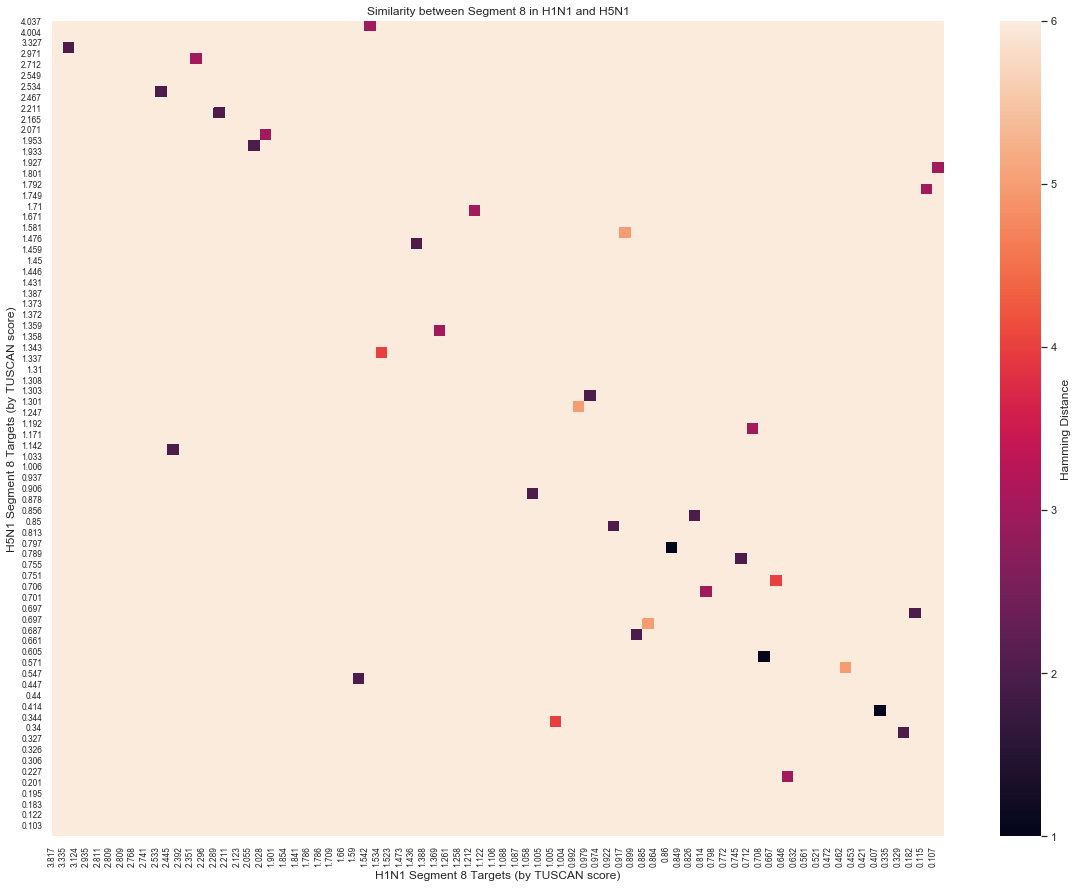

In [49]:
f, ax = plt.subplots(1, 1, figsize = (20, 15))
ax = sns.heatmap(HammingMatrix, cbar_kws={'label': 'Hamming Distance'})
ax.set_xticks(np.arange(len(H1N1.index))) #columns are H1N1
ax.set_yticks(np.arange(len(H5N1.index))) #rows are H5N1
ax.set_xticklabels([round(float(row["TUSCAN_Score"]), 3) for index, row in H1N1.iterrows()], rotation=90, fontsize = 'small')
ax.set_yticklabels([round(float(row["TUSCAN_Score"]), 3) for index, row in H5N1.iterrows()], rotation=0, fontsize = 'small')
ax.set_title("Similarity between Segment 8 in H1N1 and H5N1")
ax.set(xlabel="H1N1 Segment 8 Targets (by TUSCAN score)", ylabel="H5N1 Segment 8 Targets (by TUSCAN score)")
plt.show()

## Extracting the most active and most unique targets from each virus

We would like the targets with the highest TUSCAN score and with a hamming distance of at least 6 against all opposing viral targets. 

##### H1N1 Targets:

In [52]:
indexes = []
for count, b in enumerate(HammingMatrix.min(axis=0)):
    if b == 6:
        indexes.append(count)
H1N1.iloc[indexes].head()

,Chrom,Start,End,Strand,Candidate_sgRNA,TUSCAN_Score
45,8,673,695,+,GCAATTGGGACAGAAATTTGAGG,3.817165
76,8,108,130,-,TTAAGGACTTTTGATCTCGGCGG,3.124494
35,8,435,457,+,ACTACTAAGGGCTTTCACTGAGG,2.935428
33,8,345,367,+,TTGCGTGCGATTGGACCAGGCGG,2.810570
30,8,267,289,+,CCTTTCTGACATGACCCTCGAGG,2.808692


##### H5N1 Targets:

In [53]:
indexes = []
for count, b in enumerate(HammingMatrix.min(axis=1)):
    if b == 6:
        indexes.append(count)
H5N1.iloc[indexes].head()

,Chrom,Start,End,Strand,Candidate_sgRNA,TUSCAN_Score
0,8,215,237,+,AATAGTGGAGCGGATTCTGGAGG,4.003982
31,8,230,252,+,TCTGGAGGAGGAGTCCGATAAGG,2.711539
36,8,323,345,+,GCTCATGCCCAAGCAGAAAGTGG,2.548915
40,8,461,483,+,CACAGAAGAAGGAGCAATCGTGG,2.467114
44,8,614,636,+,CGTTTGGAGAAGCAGTGATGAGG,2.164712
